# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import spacy

from nltk import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_auc_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm

Инициализируем глобальные константы.

In [169]:
RANDOM_STATE = 42
REQUIRED_F1 = 0.75

Загрузим необходимые компоненты nltk.

In [3]:
nltk.download(
    [
        'averaged_perceptron_tagger',
        'omw',
        'punkt',
        'stopwords',
        'wordnet'
    ]
)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Загрузим данные и выведем первые пять случайных строк.

In [4]:
comments_df = pd.read_csv('/datasets/toxic_comments.csv')
comments_df.sample(5)

,text,toxic
21277,"""This IP address has been blocked because it i...",0
44579,"""Sorry I messed up. Can you find a different w...",0
146969,"""\nChessCreator, I am asking you to stop. You...",0
111900,Totally laughable. Not only are you not righ...,0
38553,REDIRECT Talk:Alaska class cruiser/GA1,0


Данные загружены корректно.

Посмотрим, какие типы данных были определены и есть ли пропуски в данных.

In [5]:
comments_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 80.1 MB


Пропусков нет.

Посмотрим на баланс классов в целевом столбце.

In [136]:
comments_df['toxic'].value_counts()/len(comments_df['toxic'])

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Есть небольшой дисбаланс в сторону нетоксичных комментариев (примерно 9:1). Примем данный факт во внимание и используем его при обучении моделей.

Преобразуем тексты комментариев в векторы, с которыми моделям проще работать. Для этого напишем функции очистки текста и лемматизации в зависимости от части речи.

In [6]:
def clear_text(text: str):
    """
    Очищает текст (на английском языке), приведённый к нижнему регистру, от небуквенных символов и оставляет одинарные кавычки
    для случаев с апострофами.
    
    Аргументы
    ---------
    text : str
        Тестовая строка на английском языке.
        
    Возвращает
    ----------
    text_cleared : str
        Очищенная текстовая строка.
    """
    return ' '.join(re.sub(r'[^a-z\']', ' ', text.lower()).split())

def get_wordnet_pos(word: str):
    """
    Сопоставляет тег части речи (POS-тег библиотеки nltk) с первым символом лемматизации, принятым в лемматизаторе
    wordnet.
    
    Аргументы
    ---------
    word: str
        Слово, для которого определяется часть речи.
        
    Возвращает
    ----------
    tag : str
        Символ части речи, который будет использован как аргумент лемматизации.
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text: str, lemmatizer):
    """
    Заменяет слова из очищенного текста на леммы.
    
    Аргументы
    ---------
    text : str
        Лемматизируемый текст.
    lemmatizer
        Используемый инициализированный лемматизатор, в данном случае - spacy.
        
    Возвращает
    ----------
    text_lemmatized : str
        Лемматизированный текст.
    """
    # word_list = nltk.word_tokenize(clear_text(text))
    # text_lemmatized = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])

    text_tokenized = lemmatizer(clear_text(text))
    # Исключим токены с апострофом
    text_lemmatized = ' '.join([token.lemma_ for token in text_tokenized if "'" not in token.lemma_])
    return text_lemmatized

Для лемматизации будем использовать достаточно быстрый лемматизатор из библиотеки spaCy.  
Загрузим лёгкую модель и проведём лемматизацию всех комментариев. Получившийся список положим в столбец исходного датафрейма под именем 'lemm_text'.

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

text_lemmatized = [
    lemmatize_text(comment_text, nlp)
    for comment_text in tqdm(comments_df['text'])
]

comments_df['lemm_text'] = text_lemmatized

Проверим корректность процедуры.

In [152]:
comments_df.sample(5)

,text,toxic,lemm_text
144950,", and I feel JMLK's message was a bit smug and...",0,and I feel jmlk message be a bit smug and I co...
29153,"""\n No, the main space is for notable topics t...",0,no the main space be for notable topic that be...
152692,Apparently you're learning impaired. That's o...,0,apparently you be learn impair that be okay yo...
11936,I thought the maximum has been 26% ethanol. I ...,0,I think the maximum have be ethanol I check so...
115878,"""\n\n Thanks \n\nHey Utkarshraj, thanks for th...",0,thank hey utkarshraj thank for the kindness of...


In [8]:
# Для эффективной работы выгрузим столбец с лемматизированными комментариями в файл.
# pd.Series(data=text_lemmatized, name='lemm_text').to_csv('toxic_comments_lemmatized.csv', index=False)

# Загрузим лемматизированные комментарии из подготовленного файла.
# comments_df['lemm_text'] = pd.read_csv('toxic_comments_lemmatized.csv')['lemm_text']

### Вывод

* Данные представляют собой таблицу из 159571 строки и 2 столбцов (с комментариями и целевым признаком).
* Пропущенных значений нет.
* Есть небольшой дисбаланс в сторону нетоксичных комментариев (примерно 9:1).
* Комментарии лемматизированы для дальнейшей их векторизации.

## Обучение

Разделим данные на признаки для классификации и целевой признак. Разобъём выборки на обучающую и тестовую в соотношении 4:1.

In [10]:
features = comments_df['lemm_text']
target = comments_df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target
)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((127656,), (31915,), (127656,), (31915,))

Векторизуем признаки на основе оценки важности слов в корпусе и во всём тексте (TF-IDF) с помощью инструмента встроенной библиотеки scikit-learn - TfidfVectorizer.  
Трансформер обучим на тренировочной выборке.

In [11]:
nltk_stopwords = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=nltk_stopwords)

features_train = vectorizer.fit_transform(features_train.values.astype('U'))
features_test = vectorizer.transform(features_test.values.astype('U'))

Для машинного обучения используем модель на основе метода опорных векторов, логистическую регрессию и градиентный бустинг из библиотеки LightGBM и проведём кросс-валидацию при параметрах по умолчанию - так мы получим базовое качество моделей. Результаты кросс-валидации запишем в сводную таблицу.

In [18]:
skfold = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

models_dict = {
    'Линейный классификатор на методе опорных векторов': LinearSVC(random_state=RANDOM_STATE),
    'Логистическая регрессия': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
    'Градиентный бустинг LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE)
}

scoring_list = ['roc_auc', 'f1']

cv_results_dict = {
    model_name: cross_validate(model, features_train, target_train, scoring=scoring_list, cv=skfold, n_jobs=-1,
                               return_train_score=True)
    for model_name, model in models_dict.items()
}

In [119]:
stages_ru_en = {
    'Обучение': 'train',
    'Валидация': 'test'
}
multicols = [[k for k in stages_ru_en for _ in scoring_list]] + [scoring_list*2]
score_df = pd.DataFrame(data=[], index=models_dict.keys(), columns=multicols)

for model_name in score_df.index:
    for ru, en in stages_ru_en.items():
        for scoring in scoring_list:
            score_df.loc[model_name, (ru, scoring)] = cv_results_dict[model_name][en + '_' + scoring].mean()
            
score_df

Обучение            \
                                                    roc_auc        f1   
Линейный классификатор на методе опорных векторов  0.997783  0.928215   
Логистическая регрессия                            0.985325  0.763535   
Градиентный бустинг LightGBM                       0.979946  0.794683   

                                                  Валидация            
                                                    roc_auc        f1  
Линейный классификатор на методе опорных векторов  0.967126  0.776766  
Логистическая регрессия                            0.970272  0.725658  
Градиентный бустинг LightGBM                       0.963287  0.754172

Метод опорных векторов и градиентный бустинг показали результат на валидации, удовлетворяющий требованиям (f1 >= 0.75); логистическая регрессия показала качество чуть ниже требуемого уровня, однако для логистической регрессии и градиентного бустинга можно подобрать оптимальный по f1-мере порог классификации. Заметно сильное переобучение линейной модели SVC по f1-мере, остальные модели также переобучились, но значительно слабее.

Подберём гиперпараметры для выбранных моделей методом случайного перебора по сетке с числом переборов = 10. Для метода опорных векторов будем оптимизировать по f1-мере, для логистической регрессии и градиентного бустинга будем искать гиперпараметры, максимизирующие площадь под кривой потерь (roc_auc), чтобы, выбрав впоследствии лучшие модели, рассчитать оптимальный порог классификации.

In [124]:
# Инициализируем страифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Зададим набор значений параметра регуляризации С и баланса классов
params = {
    'class_weight': [None, 'balanced'],
    'C': np.logspace(-2, 3, 20)
}

# Инициализируем и проведём кросс-валидацию
svc_grid = RandomizedSearchCV(
    estimator=models_dict['Линейный классификатор на методе опорных векторов'],
    param_distributions=params,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True
)
svc_grid.fit(features_train, target_train)

svc_best = svc_grid.best_estimator_

# Выведем результаты обучения и тестирования
train_score = svc_grid.cv_results_['mean_train_score']
test_score = svc_grid.cv_results_['mean_test_score']

print('Лучшее значение F1 на обучающей выборке: {:.3f}'.format(train_score[test_score == test_score.max()][0]))
print('Лучшее значение F1 на валидационной выборке: {:.3f}'.format(test_score.max()))
print()
print('Лучшие параметры модели SVC:')
print(svc_grid.best_params_)

Лучшее значение F1 на обучающей выборке: 0.939
Лучшее значение F1 на валидационной выборке: 0.776

Лучшие параметры модели SVC:
{'class_weight': None, 'C': 1.2742749857031335}


F1-мера практически не отличается от таковой у базовой модели, то же можно сказать и про параметр регуляризации, значит, можно оставить базовые настройки для тестирования.

Для той же сетки подберём гиперпараметры логистической регрессии.

In [126]:
# Инициализируем и проведём кросс-валидацию
log_grid = RandomizedSearchCV(
    estimator=models_dict['Логистическая регрессия'],
    param_distributions=params,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True
)
log_grid.fit(features_train, target_train)

log_best = log_grid.best_estimator_

# Выведем результаты обучения и тестирования
train_score = log_grid.cv_results_['mean_train_score']
test_score = log_grid.cv_results_['mean_test_score']

print('Лучшее значение roc_auc на обучающей выборке: {:.3f}'.format(train_score[test_score == test_score.max()][0]))
print('Лучшее значение roc_auc на валидационной выборке: {:.3f}'.format(test_score.max()))
print()
print('Лучшие параметры модели логистической регрессии:')
print(log_grid.best_params_)

Лучшее значение roc_auc на обучающей выборке: 0.995
Лучшее значение roc_auc на валидационной выборке: 0.971

Лучшие параметры модели логистической регрессии:
{'class_weight': 'balanced', 'C': 2.3357214690901213}


Значение roc_auc на валидации чуть больше, чем у базовой модели, но и на тренировочной выборке значение стало ещё ближе к единице, при этом положительная разность между качеством обучения и валидации только выросла, что говорит о небольшом усилении переобучения, но в относительных единицах оно не превышает 3%, что позволяет использовать данную модель.

Найдём оптимальные гиперпараметры для градиентного бустинга.

In [130]:
# Зададим сетку для поиска лучших значений гиперпараметров градиентного бустинга
params = {
    'n_estimators': range(50, 250, 50),     # число деревьев в ансамбле
    'max_depth': range(2, 10),              # максимальная глубина дерева
    'num_leaves': range(10, 80, 10),        # максимальное число листьев
    'min_child_samples': range(20, 110, 10) # минимальное число объектов на листе
}

# Инициализируем и проведём кросс-валидацию
lgb_grid = RandomizedSearchCV(
    estimator=models_dict['Градиентный бустинг LightGBM'],
    param_distributions=params,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True
)
lgb_grid.fit(features_train, target_train)

lgb_best = lgb_grid.best_estimator_

# Выведем результаты обучения и тестирования
train_score = lgb_grid.cv_results_['mean_train_score']
test_score = lgb_grid.cv_results_['mean_test_score']

print('Лучшее значение roc_auc на обучающей выборке: {:.3f}'.format(train_score[test_score == test_score.max()][0]))
print('Лучшее значение roc_auc на валидационной выборке: {:.3f}'.format(test_score.max()))
print()
print('Лучшие параметры модели градиентного бустинга:')
print(lgb_grid.best_params_)

Лучшее значение roc_auc на обучающей выборке: 0.961
Лучшее значение roc_auc на валидационной выборке: 0.951

Лучшие параметры модели градиентного бустинга:
{'num_leaves': 10, 'n_estimators': 150, 'min_child_samples': 60, 'max_depth': 8}


Базовая модель показала лучшее качество по метрике roc_auc, поэтому для тестирования будем использовать её.

Создадим словарь для сбора тестовых значений метрик финальных моделей.

In [159]:
test_results_dict = dict().fromkeys(models_dict.keys())

for model_name in test_results_dict:
    test_results_dict[model_name] = dict().fromkeys(scoring_list)
        
test_results_dict

{'Линейный классификатор на методе опорных векторов': {'roc_auc': None,
  'f1': None},
 'Логистическая регрессия': {'roc_auc': None, 'f1': None},
 'Градиентный бустинг LightGBM': {'roc_auc': None, 'f1': None}}

Протестируем модели и запишем полученные метрики в словарь.

In [160]:
lin_svc = models_dict['Линейный классификатор на методе опорных векторов']
lin_svc.fit(features_train, target_train)

test_results_dict['Линейный классификатор на методе опорных векторов']['f1'] = f1_score(target_test, lin_svc.predict(features_test))
test_results_dict['Линейный классификатор на методе опорных векторов']['roc_auc'] = roc_auc_score(target_test, lin_svc.predict(features_test))

test_results_dict['Линейный классификатор на методе опорных векторов']

{'roc_auc': 0.848118782189121, 'f1': 0.7809685641461341}

In [175]:
def get_f1_and_threshold(model, x, y):
    """
    Рассчитывает оптимальный порог классификации для данной модели.
    
    Аргументы
    ---------
    model : sklearn.base.BaseEstimator
        Модель бинарной классификации, для которой можно подобрать оптимальный порог классификации.
    x : array-like
        Массив признаков.
    y : array-like
        Вектор целевого признака.
        
    Возвращает
    ----------
    f1_best : float
        Лучшее значение F1-меры.
    thresh_best : float
        Оптимальный порог классификации.
    """
    f1 = []
    thresholds = np.array(np.linspace(start=0.01, stop=0.99, num=99))
    prediction_proba = model.predict_proba(x)[:, 1]
    for thresh in thresholds:
        prediction = [1 if x else 0 for x in (prediction_proba > thresh)]
        f1.append(f1_score(y, prediction))
    f1 = np.array(f1)

    thresh_best = thresholds[f1 == f1.max()][0]
    f1_best = f1.max()
    
    return f1_best, thresh_best

log_f1, log_thresh = get_f1_and_threshold(log_best, features_test, target_test)
print('Порог классификации: {}'.format(log_thresh))

test_results_dict['Логистическая регрессия']['f1'] = log_f1
test_results_dict['Логистическая регрессия']['roc_auc'] = roc_auc_score(target_test, log_best.predict_proba(features_test)[:, 1])

test_results_dict['Логистическая регрессия']

Порог классификации: 0.68


{'roc_auc': 0.9717365827494526, 'f1': 0.7910126192674669}

In [176]:
lgbc = models_dict['Градиентный бустинг LightGBM']
lgbc.fit(features_train, target_train)

lgbc_f1, lgbc_thresh = get_f1_and_threshold(lgbc, features_test, target_test)
print('Порог классификации: {}'.format(lgbc_thresh))

test_results_dict['Градиентный бустинг LightGBM']['f1'] = lgbc_f1
test_results_dict['Градиентный бустинг LightGBM']['roc_auc'] = roc_auc_score(target_test, lgbc.predict_proba(features_test)[:, 1])

test_results_dict['Градиентный бустинг LightGBM']

Порог классификации: 0.26


{'roc_auc': 0.9633987627124018, 'f1': 0.7757054041128647}

Добавим значения из словаря в сводную таблицу.

In [167]:
for model_name in score_df.index:
    for scoring in scoring_list:
        score_df.loc[model_name, ('Тестирование', scoring)] = test_results_dict[model_name][scoring]
            
score_df

Обучение            \
                                                    roc_auc        f1   
Линейный классификатор на методе опорных векторов  0.997783  0.928215   
Логистическая регрессия                            0.985325  0.763535   
Градиентный бустинг LightGBM                       0.979946  0.794683   

                                                  Валидация            \
                                                    roc_auc        f1   
Линейный классификатор на методе опорных векторов  0.967126  0.776766   
Логистическая регрессия                            0.970272  0.725658   
Градиентный бустинг LightGBM                       0.963287  0.754172   

                                                  Тестирование            
                                                       roc_auc        f1  
Линейный классификатор на методе опорных векторов     0.848119  0.780969  
Логистическая регрессия                               0.971737  0.791013  
Градиентный бустинг LightGBM                          0.963399  0.775705

Все выбранные модели показали хороший результат на тесте, при этом всем удалось преодолеть требуемое значение F1-меры в 0.75. Логистическая регрессия показала к тому же отличный результат по метрике roc_auc.

Визуализируем тестовые результаты финальных моделей.

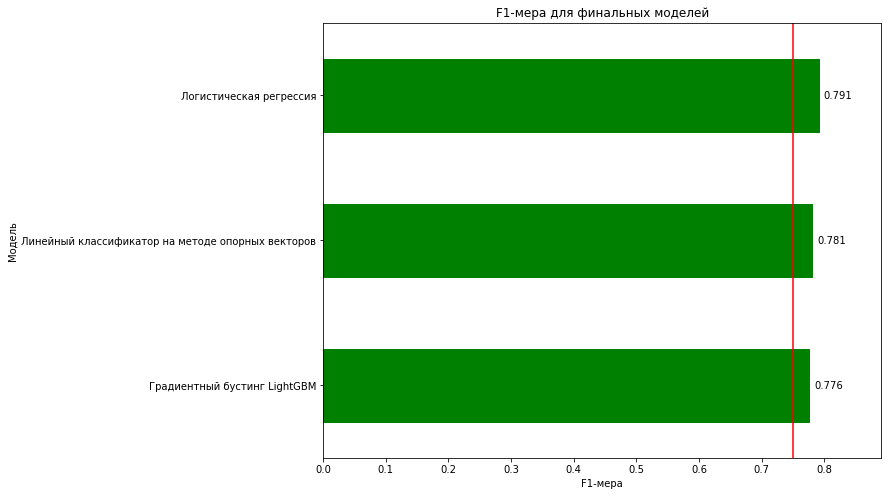

In [174]:
def add_value_labels(ax, spacing=5):
    """
    Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    rects = ax.patches
    
    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = "{:.3f}".format(x_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha                       # Horizontally align label differently for
        )                               # positive and negative values.

# Построим горизонтальную столбчатую диаграмму
ax = score_df['Тестирование', 'f1'].sort_values().plot(
    kind='barh',
    xlim=(0, score_df['Тестирование', 'f1'].max() + 0.1),
    title='F1-мера для финальных моделей',
    figsize=(10, 8),
    legend=False
)

# Не прошедшие по качеству модели отметим красным цветом, остальные - зелёным
not_passed = score_df['Тестирование', 'f1'] < REQUIRED_F1
[
    ax.get_children()[i].set_color('r')
    if b
    else ax.get_children()[i].set_color('g')
    for i, b in enumerate(not_passed)
]

ax.set_xlabel('F1-мера')
ax.set_ylabel('Модель')
add_value_labels(ax)

# Нарисуем порог по качеству
plt.axvline(REQUIRED_F1, color='red');

### Вывод

* Лемматизированные комментарии векторизованы для машинного обучения.
* Данные разделены на обучающее и тестовое подмножества в соотношении 4:1; пропорция классов целевого признака сохранена.
* Выбраны модель на основе метода опорных векторов, модели логистической регресии и градиентного бустинга из библиотеки LightGBM.
* Модели были обучены с настройками по умолчанию. Измерено качество с помощью кросс-валидации:
```
                                                       Обучение	            Валидация
                                                       roc_auc	 f1	      roc_auc	 f1
Линейный классификатор на методе опорных векторов	0.997783	0.928215	0.967126	0.776766
Логистическая регрессия	                          0.985325	0.763535	0.970272	0.725658
Градиентный бустинг LightGBM	                     0.979946	0.794683	0.963287	0.754172
```

* Проведён подбор гиперпараметров с помощью случайного поиска по сетке.
* Анализ качества моделей с подобранными гиперпараметрами показал, что только логистическая регрессия показала результат лучше, чем базовая модель.
* Результаты теста финальных моделей:
```
                                                       Тестирование
                                                       roc_auc	 f1
Линейный классификатор на методе опорных векторов	0.848119	0.780969
Логистическая регрессия	                          0.971737	0.791013
Градиентный бустинг LightGBM	                     0.963399	0.775705
```
* Таким образом, лучший результат показала модель логистической регрессии. Все модели успешно преодолели заданный порог F1-меры = 0.75.

## Выводы

* Результаты теста финальных моделей:
```
                                                       Тестирование
                                                       roc_auc	 f1
Линейный классификатор на методе опорных векторов	0.848119	0.780969
Логистическая регрессия	                          0.971737	0.791013
Градиентный бустинг LightGBM	                     0.963399	0.775705
```
* Лучший результат показала модель логистической регрессии, F1 = 0.791.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны